# Task: Text Generation

In this Notebook we run Archai's [Text Generation](https://github.com/microsoft/archai/tree/main/tasks/text_generation) task on Azure Machine Learning.

We'll use the following components:
1. [Search](./src/search.yaml) - Run Lightweight Transformer Search (LTS) to discover architectures that perform well with regards to non-embedding parameters, latency, and memory
2. [Train](./src/train.yaml) - Train a chosen architecture
3. [Generate text](./src/generate_text.yaml) - Given a trained architecture and a prompt, outputs the generated text

The components are defined via Yaml (more info [here](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-component-pipeline-python#define-component-via-yaml)) which will call the corresponding Python scripts.

Note: Our goal is to show how to create and run jobs without spending too much computing resources. Therefore, our goal is not to train a good model -- for this purpose please refer to the original task.

## Prerequisites

- Python 3.7 or later
- An Azure subscription
- An Azure Resource Group
- An Azure Machine Learning [Workspace](https://learn.microsoft.com/en-us/azure/machine-learning/quickstart-create-resources#create-the-workspace)

### Requirements

In [ ]:
%pip install azure-ai-ml azure-identity pandas
%pip install archai

In [ ]:
import os
from pathlib import Path

from IPython.display import display, Image
from IPython.core.display import HTML

from azure.ai.ml import load_job

import archai.common.azureml_helper as aml_helper
import archai.common.notebook_helper as nb_helper

### Get a handle to the workspace

We load the workspace from a workspace [configuration file](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-configure-environment#local-and-dsvm-only-create-a-workspace-configuration-file).

In [ ]:
ml_client = aml_helper.get_aml_client_from_file("../.azureml/config.json")
print(f'Using workspace: {ml_client.workspace_name} in resource group: {ml_client.resource_group_name}')

### Create CPU and GPU compute clusters

We provision a Linux [compute cluster](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-attach-compute-cluster?tabs=python) for the NAS job in this Notebook. See the [full list](https://azure.microsoft.com/en-ca/pricing/details/machine-learning/) on VM sizes and prices.

We also provision a GPU compute cluster, to train the architectures and generate text.

In [5]:
cpu_compute_name = "nas-cpu-cluster-D14-v2"
cpu_compute_cluster = aml_helper.create_compute_cluster(ml_client, cpu_compute_name, size="Standard_D14_v2")

gpu_compute_name = "nas-gpu-cluster-NC6"
gpu_compute_cluster = aml_helper.create_compute_cluster(ml_client, gpu_compute_name, size="Standard_NC6")

You already have a cluster named nas-cpu-cluster-D14-v2, we'll reuse it as is.
You already have a cluster named nas-gpu-cluster-NC6, we'll reuse it as is.


### Create an environment based on a YAML file

Azure Machine Learning maintains a set of CPU and GPU Ubuntu Linux-based base images with common system dependencies. For the set of base images and their corresponding Dockerfiles, see the [AzureML Containers](https://github.com/Azure/AzureML-Containers) repo.

In [6]:
archai_job_env = aml_helper.create_environment_from_file(ml_client, 
                                                         image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest", 
                                                         conda_file="conda.yaml",
                                                         version="0.0.1")

Environment with name aml-archai is registered to workspace, the environment version is 0.0.1


### Job 1: NAS (Searching for Pareto-optimal Architectures)

Load the search job from a YAML file and run it.

In [7]:
search_job = load_job(source=os.path.join("src", "search.yaml"))
s_job = ml_client.create_or_update(search_job)

Uploading src (0.01 MBs): 100%|##########| 10177/10177 [00:00<00:00, 10489.91it/s]




Open the job overview on Azure ML Studio in your web browser (this works when you are running this notebook in VS code).

In [8]:
import webbrowser
webbrowser.open(s_job.services["Studio"].endpoint)

job_name = s_job.name
print(f'Started job: {job_name}')

Started job: salmon_plum_t9hynvf120


Download the job's output.

In [ ]:
output_name = "output_dir"
download_path = "output"

aml_helper.download_job_output(ml_client, job_name=s_job.name, output_name=output_name, download_path=download_path)

downloaded_folder = Path(download_path) / "named-outputs" / output_name

Show the Pareto Frontiers.

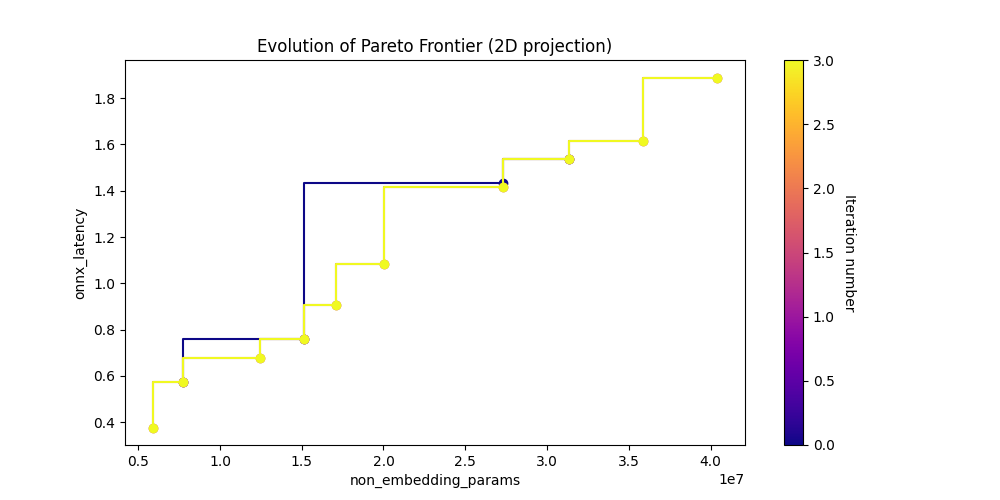

In [10]:
param_vs_latency_img = Image(filename=downloaded_folder / "pareto_non_embedding_params_vs_onnx_latency.png")
display(param_vs_latency_img)

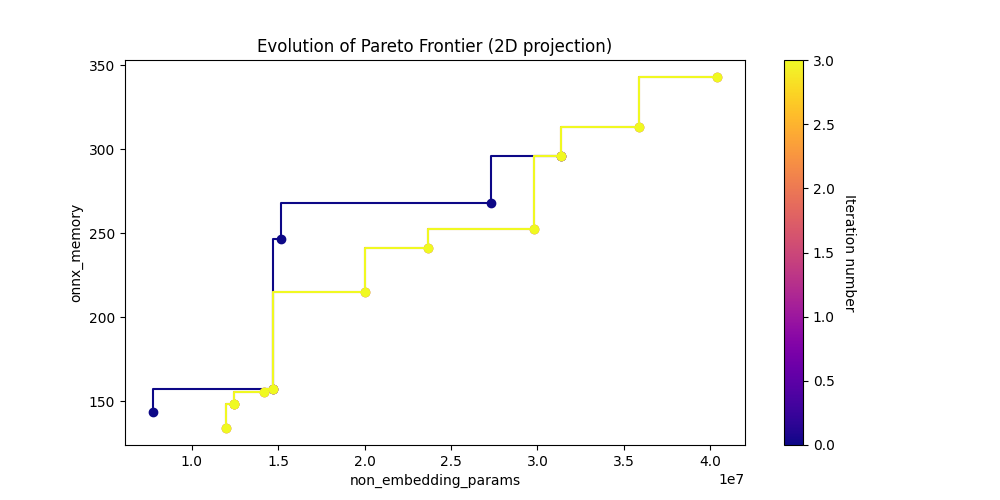

In [11]:
param_vs_memory_img = Image(filename=downloaded_folder / "pareto_non_embedding_params_vs_onnx_memory.png")
display(param_vs_memory_img)

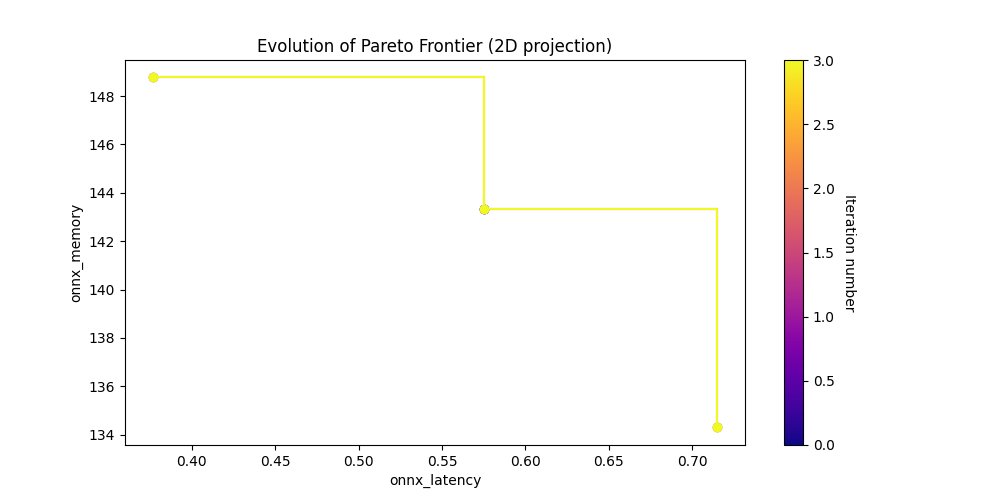

In [12]:
latency_vs_memory_img = Image(filename=downloaded_folder / "pareto_onnx_latency_vs_onnx_memory.png")
display(latency_vs_memory_img)

Show the search state of the last iteration.

In [13]:
df = nb_helper.get_search_csv(downloaded_folder)
df = df.drop('parent', axis=1)
df = df.drop('parents', axis=1)

csv_as_html = nb_helper.get_csv_as_stylized_html(df)
display(HTML(csv_as_html))

,archid,non_embedding_params,onnx_latency,onnx_memory,iteration_num,search_walltime_hours,is_pareto
0,gpt2_cea35b3f3fd242d2af609b8d2a3936cc814a7f41,15144192.000000,0.761083,246.531515,0,0.074541,True
1,gpt2_df106863e1a0c9c140036b05661aa88e92f07701,7769472.000000,0.575391,143.315580,0,0.074541,True
2,gpt2_0f371e7b893319c0d20944d60143fad14e2695d0,14724096.000000,0.850879,157.321033,0,0.074541,True
3,gpt2_889f69f6f6193194b0b78cf645bc44324928785e,31372992.000000,1.538318,295.865806,0,0.074541,True
4,gpt2_e848f3b384f04fdd238e08a79fdd2fa74d8c5194,27327616.000000,1.434555,267.924564,0,0.074541,False
5,gpt2_ecd66243c69a1a3273be0599297e7f7ca4943938,20050048.000000,1.082883,215.160275,1,0.290282,True
6,gpt2_e446e91026f819b689775cba65accbaafd81c4ef,35854592.000000,1.613641,312.946812,1,0.290282,True
7,gpt2_6606054e0222dccc9ab29ff8254706f6e190fb5b,27327616.000000,1.417154,267.924564,1,0.290282,True
8,gpt2_2ff7eebbc32f2bb8554e2241b2f1eed495d7b2a4,12431680.000000,1.038724,148.587824,1,0.290282,True
9,gpt2_85a39fce7fd60bf8df99d17bb91298a450e2b0b1,12424512.000000,0.676473,148.552288,1,0.290282,True


### Job 2: Train (Train a Pareto architecture from Transformer-Flex.)

Pick an architecture id (archid) from the CSV file to perform full training.

In [14]:
archid = "<arch-id>"
print(f"Selected architecture: {archid}")
arch_path = nb_helper.get_arch_abs_path(archid=archid, downloaded_folder=downloaded_folder)

Selected architecture: gpt2_df106863e1a0c9c140036b05661aa88e92f07701


Load the training job from a YAML file, set its input, and run it. With the GPU cluster we created it should take around 3 hours.

In [15]:
train_job = load_job(source=os.path.join("src", "train.yaml"))
train_job.inputs.arch_config_path.path = arch_path
t_job = ml_client.create_or_update(train_job)

Open the job overview on Azure ML Studio in your web browser (this works when you are running this notebook in VS code).

In [16]:
import webbrowser
webbrowser.open(t_job.services["Studio"].endpoint)

job_name = t_job.name
print(f'Started Job: {job_name}')

Started Job: willing_tree_3b22csbdtg


### Job 3: Generating text via prompt

Load the generate text job from a YAML file, set the inputs, and run it.

In [17]:
train_job = ml_client.jobs.get(t_job.name)

path = f"azureml://subscriptions/{ml_client.subscription_id}/resourcegroups/{ml_client.resource_group_name}/" \
       f"workspaces/{ml_client.workspace_name}/datastores/workspaceblobstore/paths/azureml/{train_job.name}/output_dir/"

if train_job and train_job.status == "Completed":
    gen_job = load_job(source=os.path.join("src", "generate_text.yaml"))
    gen_job.inputs.pre_trained_model_path.path = path
    gen_job.inputs.prompt = "Machine Learning"
    g_job = ml_client.create_or_update(gen_job)
else:
    print(f"Job {train_job.name} is not completed yet")

Open the job overview on Azure ML Studio in your web browser (this works when you are running this notebook in VS code).

In [18]:
import webbrowser
webbrowser.open(g_job.services["Studio"].endpoint)

job_name = g_job.name
print(f'Started Job: {job_name}')

Started Job: orange_bee_dk3c1xm55z


Download and show the generated text.

In [ ]:
output_name = "output_path"
download_path = "generated_text"

aml_helper.download_job_output(ml_client, job_name=g_job.name, output_name=output_name, download_path=download_path)

In [25]:
downloaded_file = Path(download_path) / "named-outputs" / output_name / output_name
with open(downloaded_file, "r") as f:
    print(f.read())

Machine Learning to continue to attend the main park in the first series. The team was considered to be used to be shot in the future. The series's longest @-@ hour of the main characters and the highest @-@ time, a series, to be used in the final series. It has been played by the series of the American, which was given by the United States and was replaced by the United States during the North America. 
 = = Plot summary = 
 The episode received by many occasions. It was a three years, and the series of the rest of the United States for the family of the previous episode,
